In [1]:
!python --version

Python 3.12.10


In [1]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch
from typing import Literal
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
class BCSSDataset(Dataset):
    SIZE=(224, 224)
#     _img_transformer = transforms.Compose([
#             transforms.Resize(SIZE),
#             transforms.PILToTensor(),
#             transforms.ConvertImageDtype(torch.float),
#             transforms.Normalize(mean=MEAN, std=STD),
#         ])
    _mask_transformer = transforms.Compose([
            transforms.Resize(SIZE),
            transforms.PILToTensor(),
        ])
    
    def __init__(self, path: str, split: Literal['train', 'val', 'test'] = 'train'):
        path = os.path.abspath(path)
        image_path = os.path.join(path, split)
        self.images = [os.path.join(image_path, filename) for filename in os.listdir(image_path)]
        mask_path = os.path.join(path, f'{split}_mask')
        self.masks = [os.path.join(mask_path, filename) for filename in os.listdir(mask_path)]

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx: int):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = Image.open(self.masks[idx])
        mask = self._mask_transformer(mask)
        mask = torch.squeeze(mask, 0).long()
        mask = (mask == 1).to(torch.uint8) # convert to 0/1 mask
        

        return image, mask

In [3]:
NUM_CLASSES = 22
IMAGE_PATH='../data/BCSS'
train_dataset = BCSSDataset(path=IMAGE_PATH, split='train')
val_dataset = BCSSDataset(path=IMAGE_PATH, split='val')

In [4]:
torch.cuda.is_available()

True

In [5]:
batch = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch, shuffle=False)

In [6]:
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
)

In [7]:
device

device(type='cuda', index=0)

In [8]:
train_dataset[0][0].shape

(224, 224, 3)

In [9]:
train_dataset[0][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [10]:
model_checkpoint="../model_checkpoint/sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=model_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
masks = mask_generator.generate(train_dataset[0][0])

In [12]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 379,
 'bbox': [204, 55, 19, 23],
 'predicted_iou': 0.9914757013320923,
 'point_coords': [[213.5, 73.5]],
 'stability_score': 0.969072163105011,
 'crop_box': [0, 0, 224, 224]}

In [13]:
def show_anns(masks):
    if len(masks) == 0:
        return
    sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [14]:
len(masks)

46

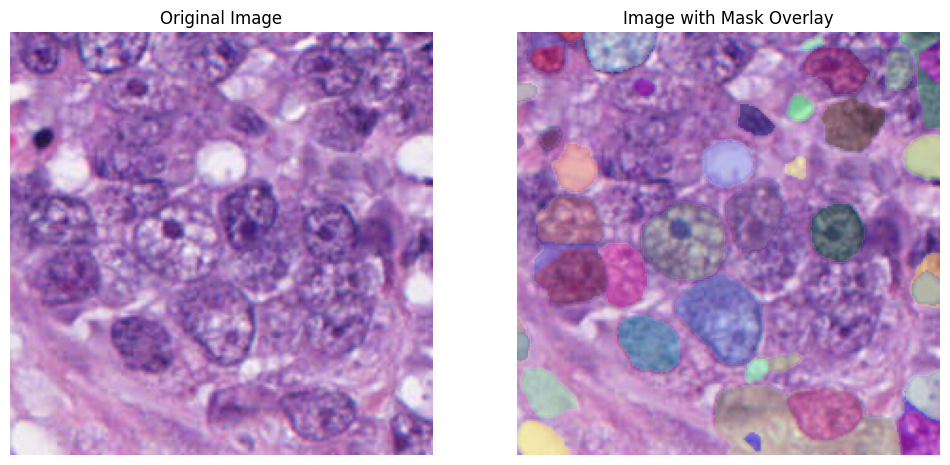

In [15]:
# plt.figure(figsize=(20, 20))
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.title('Original Image')
plt.axis('off')

# Plot image with mask overlay
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][0])
show_anns(masks)
plt.title('Image with Mask Overlay')
plt.axis('off')

plt.show()

In [16]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=2,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.50,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [17]:
masks = mask_generator_2.generate(train_dataset[0][0])

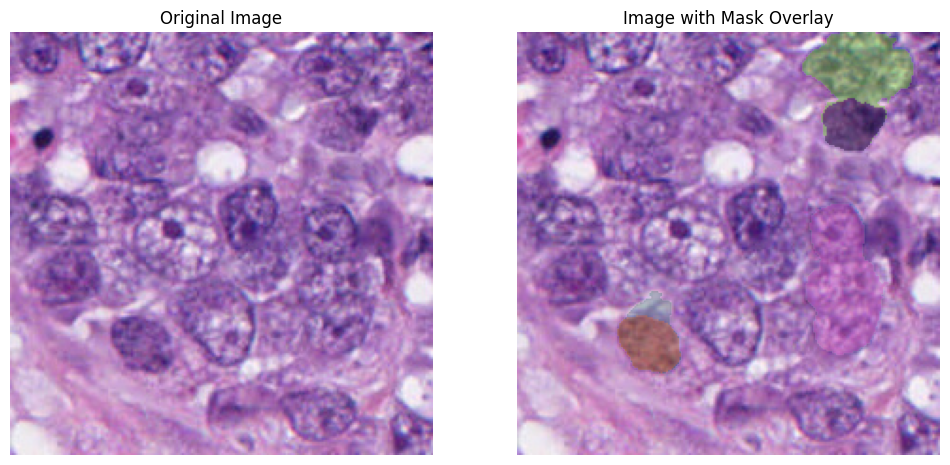

In [18]:
# plt.figure(figsize=(20, 20))
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.title('Original Image')
plt.axis('off')

# Plot image with mask overlay
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][0])
show_anns(masks)
plt.title('Image with Mask Overlay')
plt.axis('off')

plt.show()

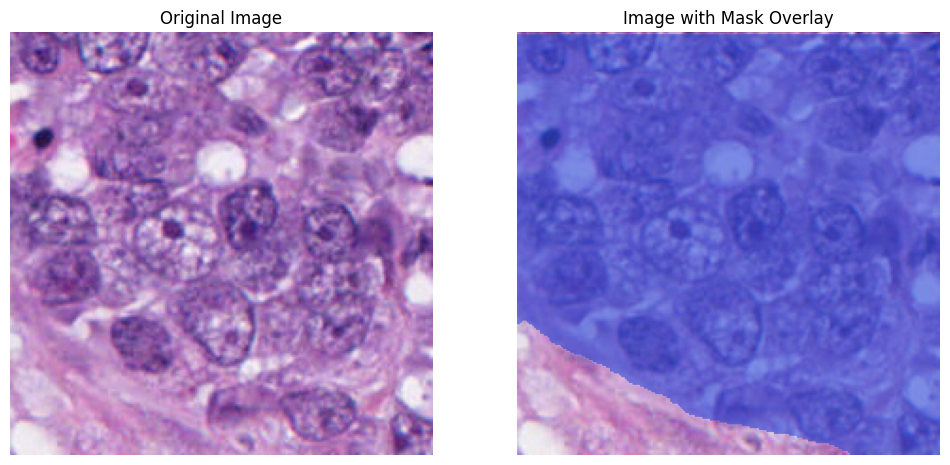

In [31]:
color_arr = np.random.random(3)
def show_mask(mask,color_arr=color_arr):
        ax = plt.gca()
        ax.set_autoscale_on(False)
        mask = (mask==1)
        img = np.ones((mask.shape[0], mask.shape[1], 4))
        img[:,:,3] = 0
        m = mask
        color_mask = np.concatenate([color_arr, [0.6]])
        img[m] = color_mask
        ax.imshow(img)
def plot_sample(dataset, idx):
    """
    Plot a sample image and its mask from the dataset.

    Args:
        dataset (Dataset): The custom BCSSDataset instance.
        idx (int): Index of the sample to be plotted.
    """
    image, mask = dataset[idx]
#     image_np = image.permute(1, 2, 0).numpy()  # Convert from PyTorch tensor to numpy array
    mask_np = mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot image with mask overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    show_mask(mask_np)
    plt.title('Image with Mask Overlay')
    plt.axis('off')

    plt.show()
sample_idx = 0  # You can change this index to visualize different samples
plot_sample(train_dataset, sample_idx)

In [28]:
train_dataset[0][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [29]:
masks[0]['segmentation']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])